In [1]:
import os
import cell_lineage_tracking as lineage
import gnn_ben_haim as bh_track
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
torch.set_default_dtype(torch.float32)
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import BaseTransform
import torch.nn as nn
from torch.utils.data import Subset
import lineage_detection

In [2]:
train_cells_filename = '/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_tracking_training_data.pkl'
all_lineages_df = pd.read_pickle(train_cells_filename)

In [3]:
# baeS tracked lineage had cells that didn't grow well
df_for_training = all_lineages_df[~(all_lineages_df['gene'] == 'baeS')]

In [4]:
# give ground truth lineages unqiue ids
df_for_training['unique_lineages'] = df_for_training['experiment_name'].astype(str) + '_' + df_for_training['trench_id'].astype(str) + '_' + df_for_training['ground_truth_lineage'].astype(str)
# Convert lineage IDs to unique integers as labels
all_unique_lineages = sorted(df_for_training['unique_lineages'].unique())
lineage_to_int_mapping = {lineage: i for i, lineage in enumerate(all_unique_lineages)}
num_lineage_classes = len(all_unique_lineages)
df_for_training['numeric_lineage'] = df_for_training['unique_lineages'].map(lineage_to_int_mapping)
df_for_training['node_id'] = df_for_training.index

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_62362/592007538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_training['unique_lineages'] = df_for_training['experiment_name'].astype(str) + '_' + df_for_training['trench_id'].astype(str) + '_' + df_for_training['ground_truth_lineage'].astype(str)
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_62362/592007538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_training['numeric_lineage'] = df_for_training['unique_line

In [5]:
df_for_training.columns

Index(['label', 'area', 'coords', 'centroid_y', 'centroid_x',
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor', 'time_frame',
       'experiment_name', 'FOV', 'trench_id', 'track_id', 'node_id',
       'ground_truth_lineage', 'gene', 'unique_lineages', 'numeric_lineage'],
      dtype='object')

In [6]:
def generate_ground_truth_links(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates the 'ground_truth_link_next_id' column based on 'ground_truth_lineage'
    for a single, sorted group of data.
    """
    df['ground_truth_link_next_id'] = [[] for _ in range(len(df))]
    
    lineage_lookup = df.set_index(['time_frame', 'ground_truth_lineage'])['node_id'].to_dict()

    for index, row in df.iterrows():
        current_t = row['time_frame']
        next_t = current_t + 1
        current_lineage = row['ground_truth_lineage']
        
        links = []

        # Case 1: Continuation
        if (next_t, current_lineage) in lineage_lookup:
            links.append(lineage_lookup[(next_t, current_lineage)])
        
        # Case 2: Division
        else:
            daughter1_lineage = f"{current_lineage}.1"
            daughter2_lineage = f"{current_lineage}.2"

            if (next_t, daughter1_lineage) in lineage_lookup:
                links.append(lineage_lookup[(next_t, daughter1_lineage)])
            
            if (next_t, daughter2_lineage) in lineage_lookup:
                links.append(lineage_lookup[(next_t, daughter2_lineage)])
        
        df.at[index, 'ground_truth_link_next_id'] = links
        
    return df

def process_all_data(df_full: pd.DataFrame) -> pd.DataFrame:
    """
    Groups the full DataFrame and applies the generation function to each group.
    
    Args:
        df_full (pd.DataFrame): The complete DataFrame with all experiments, FOVs, and trenches.

    Returns:
        pd.DataFrame: The full DataFrame with the 'ground_truth_link_next_id' column added.
    """
    # Group the DataFrame by the specified columns
    grouped_data = df_full.groupby(['experiment_name', 'FOV', 'trench_id'])

    # Apply the generate_ground_truth_links function to each group and combine the results
    result_df = grouped_data.apply(generate_ground_truth_links).reset_index(drop=True)

    return result_df

In [7]:
df_all_data_with_links = process_all_data(df_for_training)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_62362/197323387.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = grouped_data.apply(generate_ground_truth_links).reset_index(drop=True)


In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [9]:
node_feature_cols = ['area', 'centroid_y', 
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor']
for col in node_feature_cols:
    df_all_data_with_links[col] = df_all_data_with_links[col].astype(np.float32);   

In [10]:
# Identify all unique time frames across the entire dataset.
unique_time_frames = df_all_data_with_links['time_frame'].unique()
sorted_time_frames = sorted(unique_time_frames)

# Define the split points based on the number of unique time frames.
# This ensures a time-based split.
train_split_idx = int(len(sorted_time_frames) * 0.6)
val_split_idx = int(len(sorted_time_frames) * 0.8)

#Create three separate DataFrames based on the time frame split.
train_df =df_all_data_with_links[df_all_data_with_links['time_frame'].isin(sorted_time_frames[:train_split_idx])]
val_df = df_all_data_with_links[df_all_data_with_links['time_frame'].isin(sorted_time_frames[train_split_idx:val_split_idx])]
test_df = df_all_data_with_links[df_all_data_with_links['time_frame'].isin(sorted_time_frames[val_split_idx:])]

# Access the node features from the single train_df DataFrame.
all_train_node_features_df = train_df[node_feature_cols].values.astype(np.float32)

# Initialize and fit the scaler on the training data.
scaler = StandardScaler()
scaler.fit(all_train_node_features_df)
print("Scaler fitted on training data.")

# Create an instance of the transform with the fitted scaler.
transform = bh_track.StandardScalerTransform(scaler)


train_dataset = bh_track.CellTrackingDataset(root='./processed_data_bh/train',
                                    df_cells=train_df,
                                    node_feature_cols=node_feature_cols,
                                    device=device,
                                    pre_transform=transform) # Apply the scaling transform here

val_dataset = bh_track.CellTrackingDataset(root='./processed_data_bh/val',
                                  df_cells=val_df,
                                  node_feature_cols=node_feature_cols,
                                  device=device,
                                  pre_transform=transform)

test_dataset = bh_track.CellTrackingDataset(root='./processed_data_bh/test',
                                   df_cells=test_df,
                                   node_feature_cols=node_feature_cols,
                                   device=device,
                                   pre_transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Scaler fitted on training data.
Starting data processing for processed_data_bh/train...


Processing...


Finished processing. Created 10 PyG Data objects.
Processed data saved to processed_data_bh/train/processed/cell_tracking_fovs.pt
Starting data processing for processed_data_bh/val...


Done!
Processing...


Finished processing. Created 5 PyG Data objects.
Processed data saved to processed_data_bh/val/processed/cell_tracking_fovs.pt
Starting data processing for processed_data_bh/test...
Finished processing. Created 4 PyG Data objects.
Processed data saved to processed_data_bh/test/processed/cell_tracking_fovs.pt
Number of training graphs: 1
Number of validation graphs: 1
Number of test graphs: 1


Done!
Processing...
Done!


# Try Ben Haim model

In [11]:
normalized_radius_threshold = 12
num_node_features = len(node_feature_cols)
initial_edge_feature_dim = len(node_feature_cols) + 1
hidden_channels = 128 # balance between expressiveness and compute
epochs = 500
learning_rate = 0.001
best_val_acc = -1.0  # save the model with the highest validation accuracy
best_val_loss = float('inf') # track the lowest validation loss for early stopping
epochs_no_improve = 0  # Counter for epochs without validation loss improvement
patience = 10 # How many epochs to wait for improvement before stopping

# Instantiate the model with the new parameters
model = bh_track.LineageLinkPredictionGNN(in_channels=num_node_features,
    initial_edge_channels=initial_edge_feature_dim, 
    hidden_channels=128,
    num_blocks=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

print("\nStarting link prediction training...")
for epoch in range(1, epochs + 1):

    train_loss = bh_track.train_dynamic(model, 
                                       train_loader, 
                                       optimizer, 
                                       device = device)
        
    val_loss, val_acc, val_auc, val_df= bh_track.evaluate_dynamic(model,
                                                           val_loader, 
                                                           device,
                                                           node_lineage_map=None)

    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    print(f'Epoch: {epoch:03d}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_link_prediction_model.pt')
        print(f"  --> New best validation accuracy. Model saved.")
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience: # patience is another hyperparameter you'd define
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss.")
            break

print("\nTraining complete!")


Starting link prediction training...
Epoch: 001, Train Loss: 0.6974, Val Loss: 0.6376, Val Acc: 0.7234
  --> New best validation accuracy. Model saved.
Epoch: 002, Train Loss: 0.6416, Val Loss: 0.6003, Val Acc: 0.7234
Epoch: 003, Train Loss: 0.6094, Val Loss: 0.5747, Val Acc: 0.7234
Epoch: 004, Train Loss: 0.5881, Val Loss: 0.5565, Val Acc: 0.7234
Epoch: 005, Train Loss: 0.5744, Val Loss: 0.5433, Val Acc: 0.7234
Epoch: 006, Train Loss: 0.5642, Val Loss: 0.5328, Val Acc: 0.7330
  --> New best validation accuracy. Model saved.
Epoch: 007, Train Loss: 0.5534, Val Loss: 0.5235, Val Acc: 0.7368
  --> New best validation accuracy. Model saved.
Epoch: 008, Train Loss: 0.5414, Val Loss: 0.5145, Val Acc: 0.7388
  --> New best validation accuracy. Model saved.
Epoch: 009, Train Loss: 0.5289, Val Loss: 0.5054, Val Acc: 0.7445
  --> New best validation accuracy. Model saved.
Epoch: 010, Train Loss: 0.5165, Val Loss: 0.4959, Val Acc: 0.7474
  --> New best validation accuracy. Model saved.
Epoch: 0

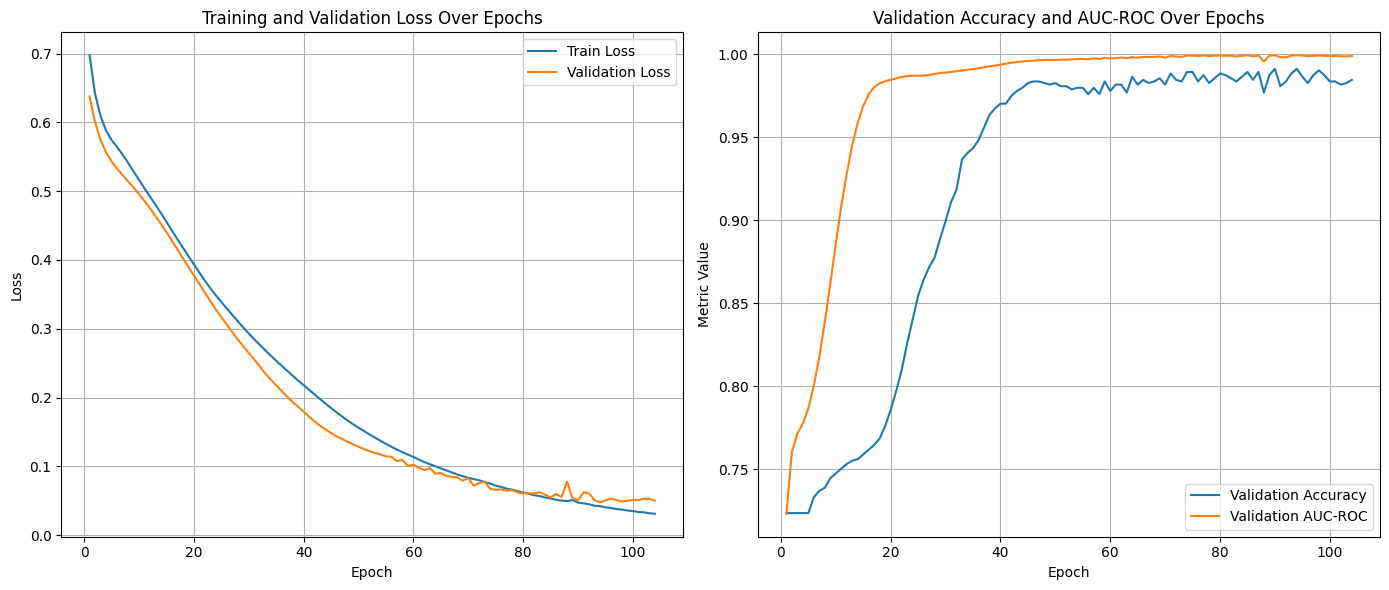

In [13]:
# Plotting the Results
epochs_range = range(1, len(train_losses) + 1) 

plt.figure(figsize=(14, 6)) 

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy and AUC-ROC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, val_aucs, label='Validation AUC-ROC')
plt.title('Validation Accuracy and AUC-ROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
node_lineage_dict = df_all_data_with_links['ground_truth_lineage'].to_dict()

In [15]:
normalized_radius_threshold = 12
num_node_features = len(node_feature_cols)
initial_edge_feature_dim = len(node_feature_cols) + 1
hidden_channels = 128 # balance between expressiveness and compute
learning_rate = 0.001
model = bh_track.LineageLinkPredictionGNN(in_channels=num_node_features,
    initial_edge_channels=initial_edge_feature_dim, 
    hidden_channels=128,
    num_blocks=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1, device=device))
# Load the best model before final evaluation
model.load_state_dict(torch.load('best_link_prediction_model.pt'))
print("Loaded best model for final test evaluation.")

# Evaluation on Test Set
print("\n Evaluating on Test Set")
test_loss, test_acc, test_auc, test_predictions_df = bh_track.evaluate_dynamic(model,
                                                                               test_loader,
                                                                               device,
                                                                               node_lineage_map=node_lineage_dict)

print(f"Final Test Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, AUC-ROC: {test_auc:.4f}")

Loaded best model for final test evaluation.

 Evaluating on Test Set
Final Test Results: Loss: 0.0647, Accuracy: 0.9860, AUC-ROC: 0.9979


In [18]:
test_predictions_df['Derived_lineage'].unique()

array(['Unknown_Edge_Lineage', 'POS_(A.1.1_to_A.2.2.2.2.2.2.1.2.1)',
       'NEG_(A.1.1_to_A.1.2)',
       'NEG_(A.2.2.2.2.1.2_to_A.2.2.2.2.2.2.1.2.1)',
       'POS_(A.2.2.2.2.1.2_to_A.1.2)', 'NEG_(A.2.2.2.2.1.2_to_B.1)',
       'NEG_(B.1.2_to_A.1.2)', 'NEG_(B.1.2_to_B.1)',
       'NEG_(B.2.2.2_to_A.1.2)', 'POS_(B.2.2.2_to_B.1)',
       'POS_(A.2.2.2.2.2.2.1.2.1_to_A.2.2.2.2.1.1)',
       'NEG_(A.2.2.2.2.2.2.1.2.1_to_A.2.2.2.1.2)',
       'NEG_(A.1.2_to_A.2.2.2.2.1.1)', 'POS_(A.1.2_to_A.2.2.2.1.2)',
       'NEG_(B.1_to_A.2.2.2.1.2)', 'POS_(A.2.2.2.2.1.1_to_A.1.2.2)',
       'NEG_(A.2.2.2.2.1.1_to_A.2.1.2.2)', 'NEG_(A.2.2.2.1.2_to_A.1.2.2)',
       'POS_(A.2.2.2.1.2_to_A.2.1.2.2)', 'NEG_(A.2.2.2.1.2_to_A.1)',
       'NEG_(A.2.2.2.1.2_to_B.1)', 'POS_(A.1.2.2_to_A.2.2.1.2)',
       'NEG_(A.1.2.2_to_A.2.2.2.2.1.1)', 'NEG_(A.2.1.2.2_to_A.2.2.1.2)',
       'POS_(A.2.1.2.2_to_A.2.2.2.2.1.1)', 'NEG_(A.2.1.2.2_to_A.1)',
       'NEG_(A.1_to_A.2.2.2.2.1.1)', 'POS_(A.1_to_A.1)',
       'NEG_(A.1_t

In [42]:
test_predictions_df[(test_predictions_df['Derived_lineage']== 'Unknown_Edge_Lineage') & 
    (test_predictions_df['Destination_Node']== '22559')]

Empty DataFrame
Columns: [Source_Node, Destination_Node, Predicted_Probability, Predicted_Label, True_Label, Derived_lineage]
Index: []

# Plot predicted vs ground truth lineage for test kymographs

In [20]:
df_consolidated_lineages =  lineage_detection.process_all_fovs(test_predictions_df, df_all_data_with_links, prob_threshold=0.8)

Column 'ground_truth_lineage' found. Including it in node attributes.
--- Processing FOV 1/4: DUMM_giTG064_Glucose_022625, 001, 867 ---
--- Adding nodes with all experimental data... ---
--- Building initial graph with edges... ---
Initial graph has 39 nodes and 28 edges.

All cycles have been removed.
Final graph has 39 nodes and 28 edges.
Successfully generated 28 lineage rows.
--- Processing FOV 2/4: DUMM_giTG62_Glucose_012925, 005, 445 ---
--- Adding nodes with all experimental data... ---
--- Building initial graph with edges... ---
Initial graph has 75 nodes and 66 edges.

All cycles have been removed.
Final graph has 75 nodes and 66 edges.
Successfully generated 66 lineage rows.
--- Processing FOV 3/4: DUMM_giTG69_Glucose_013025, 007, 295 ---
--- Adding nodes with all experimental data... ---
--- Building initial graph with edges... ---
Initial graph has 10 nodes and 9 edges.

All cycles have been removed.
Final graph has 10 nodes and 9 edges.
Successfully generated 9 lineage ro

In [21]:
df_for_kymograph_plot = lineage_detection.consolidate_lineages_to_node_df(df_consolidated_lineages, df_all_data_with_links)

--- Consolidating lineage data to a node-centric format... ---
--- Consolidation complete. Final DataFrame is ready for plotting. ---


In [47]:
unique_fovs = df_consolidated_lineages[['experiment_name', 'FOV', 'trench_id']].drop_duplicates().to_records(index=False)

In [33]:
def plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, track_id_col='track_id'):
    fig, ax = plt.subplots(1,1, figsize=(40, 10))

    # Get kymograph shape once for both calls
    kymograph_shape = phase_kymograph.shape

    ax.imshow(phase_kymograph, cmap = 'grey')
    _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')


    # ax[0].imshow(phase_kymograph, cmap = 'grey')
    # _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    # ax[0].set_yticks([])
    # ax[0].set_xticks([])
    # ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    # ax[1].imshow(fluor_kymograph, cmap = 'grey')
    # _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    # ax[1].set_yticks([])
    # ax[1].set_xticks([])
    # ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames")
    plt.tight_layout()

def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = None):
    default_cell_contour_color = '#AA5486'
    default_centroid_color = '#FC8F54'
    text_color = 'white' # Color for the track ID text
    text_offset_x = 5 # Offset the text slightly from the centroid to avoid overlap
    text_offset_y = 0

    # Prepare data for LineCollection for contours
    all_contours_segments = []
    all_contour_colors = []
    
    # Prepare data for centroids
    centroid_x_coords = []
    centroid_y_coords = []
    centroid_colors = []

    all_text_params = []

    if lineage_col:
        unique_track_ids = full_region_df[lineage_col].dropna().unique()
        colors_cmap = plt.get_cmap('tab20', len(unique_track_ids))
        track_colors = {track_id: colors_cmap(i) for i, track_id in enumerate(unique_track_ids)}

    for index, region_props in full_region_df.iterrows():
        # 'coords' are assumed to be (row, col) pixels within the mask
        cell_pixel_coords = np.array(region_props['coords']) # e.g., [[r1,c1], [r2,c2], ...]

        # Calculate bounding box for the current cell's mask
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)

        # Create a small temporary mask for the current cell
        # Add a small buffer to ensure contours are fully captured if they go to edge
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)

        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)

        # Map cell_pixel_coords to relative coordinates within temp_mask
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        
        # Populate the temporary mask
        temp_mask[relative_rows, relative_cols] = 1

        # Find contours on this small temporary mask
        # level=0.5 means it finds contours at the boundary between 0 and 1
        # fully_connected='high' means it considers 8-connectivity for background, 4-connectivity for foreground
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')

        if not contours:
            continue # Skip if no contour found (e.g., single pixel or degenerate mask)

        # `find_contours` returns (row, col) coordinates for the contour.
        # We need to convert them back to global kymograph coordinates.
        # And convert to (x, y) for plotting (col, row)
        global_contours = []
        for contour in contours:
            # Shift back to global coordinates and swap for (x, y) plotting
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            global_contours.append(np.vstack([global_contour_x, global_contour_y]).T)

        y_coord = region_props[y_coord_col]
        x_coord = region_props[x_coord_col]
        
        # Determine color for the current cell
        if lineage_col and region_props[lineage_col] in track_colors:
            current_color = track_colors[region_props[lineage_col]]
        else:
            current_color = default_cell_contour_color

        # Add all contours for this cell to the main list, with the determined color
        for contour_segment in global_contours:
            all_contours_segments.append(contour_segment)
            all_contour_colors.append(current_color)
            
        # Add centroid data
        centroid_x_coords.append(x_coord)
        centroid_y_coords.append(y_coord)
        centroid_colors.append(current_color if lineage_col else default_centroid_color)
        
        # --- Add Track ID Text ---
        if lineage_col and pd.notna(region_props[lineage_col]):
            track_id = region_props[lineage_col]
            # Convert track_id to int if it's a float, for cleaner display
            if isinstance(track_id, float) and track_id.is_integer():
                track_id_display = int(track_id)
            else:
                track_id_display = track_id

            all_text_params.append({
                'x': x_coord + text_offset_x,
                'y': y_coord + text_offset_y,
                's': str(track_id_display),
                'color': text_color,
                'fontsize': 8,
                'ha': 'left', # horizontal alignment
                'va': 'center', # vertical alignment
                'bbox': dict(facecolor=current_color, edgecolor='none', alpha=0.6, pad=1.0) # Background box
            })

    # Plot all cell contours at once using LineCollection
    if all_contours_segments: # Only plot if there are segments to draw
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=0.5)
        ax.add_collection(line_collection)

    # Plot all centroids at once using scatter
    if centroid_x_coords: # Only plot if there are centroids
        ax.scatter(centroid_x_coords, centroid_y_coords, color=centroid_colors, s=5, zorder=2)
    # Plot all track ID text at once
    for params in all_text_params:
        ax.text(params['x'], params['y'], params['s'], color=params['color'],
                fontsize=params['fontsize'], ha=params['ha'], va=params['va'],
                bbox=params['bbox'])

In [49]:
exp, fov, trench = unique_fovs[0]

In [50]:
unique_fovs[0]

np.record(('DUMM_giTG064_Glucose_022625', '001', '867'), dtype=[('experiment_name', 'O'), ('FOV', 'O'), ('trench_id', 'O')])

In [51]:
df_for_kymograph_plot['predicted_lineage'].unique()

array(['No Predicted Link', '1.1', '2', '1.2', '3', '5', '4', '6', '7',
       '8', '9.1', '10', '11', '9.2', '1', '8.2', '8.1', '9', '3.1',
       '3.2'], dtype=object)

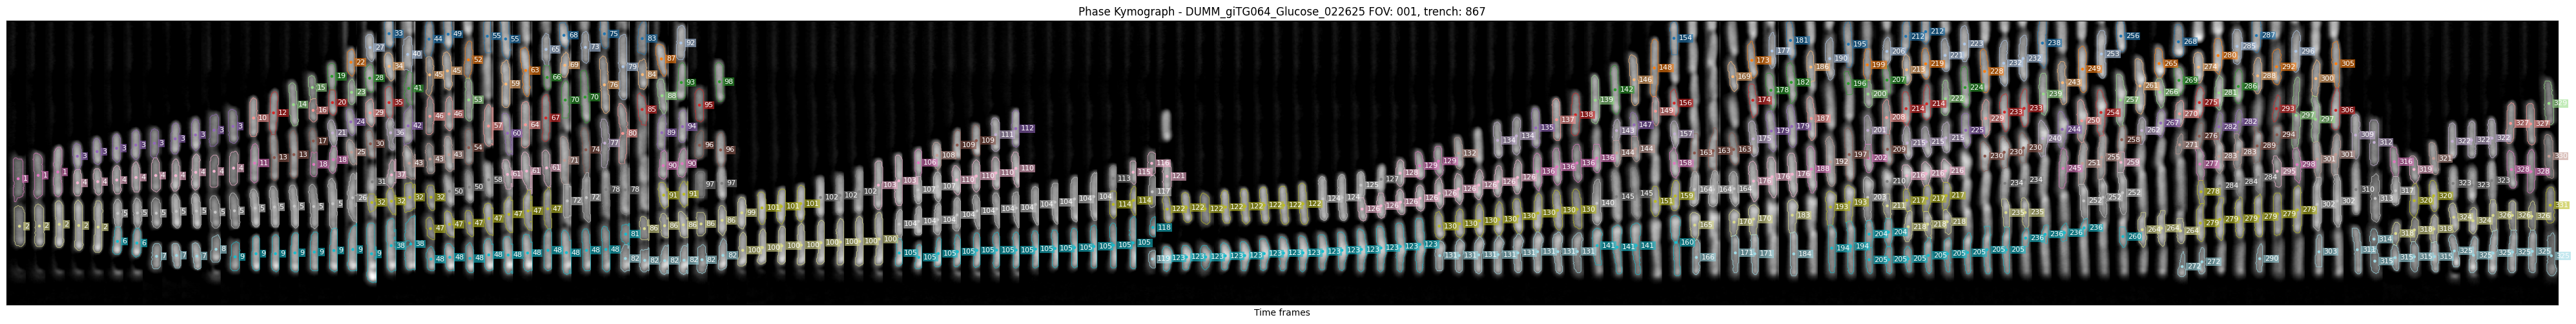

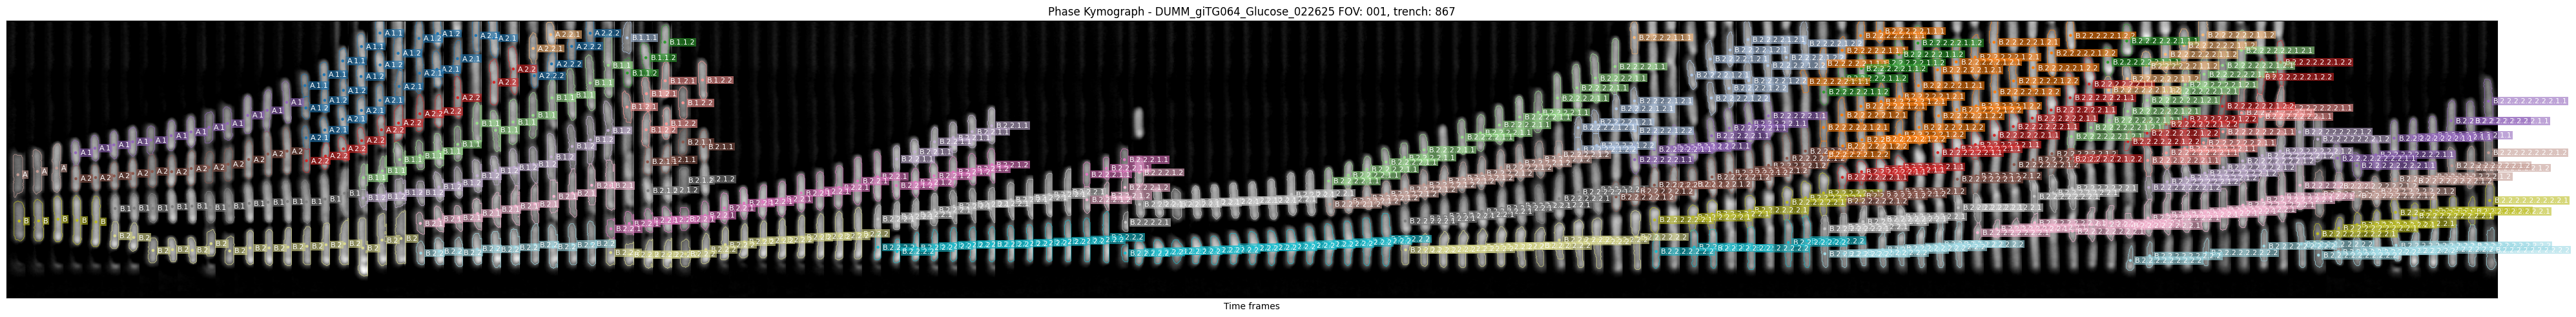

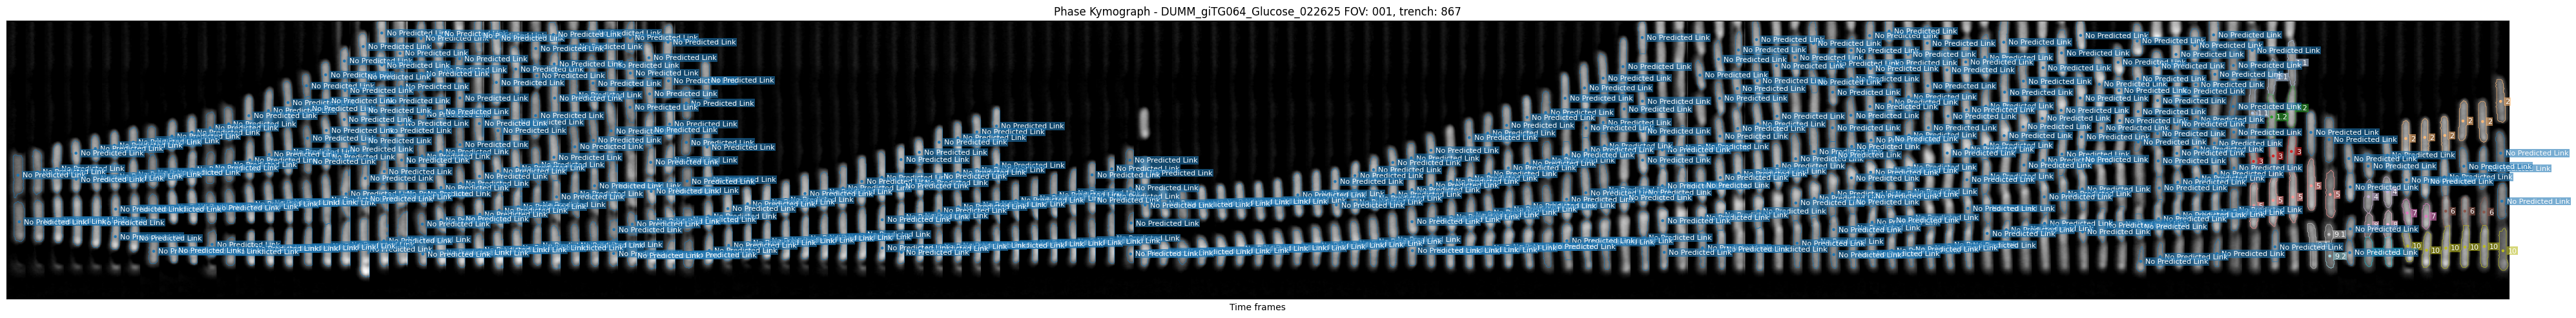

In [52]:
# path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/{fov}_{trench}.tif'
# path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}//hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/fluor/{fov}_{trench}.tif'


path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov}_{trench}.tif'
path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov}_{trench}.tif'

# path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/kymographs/phase/{fov}_{trench}.tif'
# path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/kymographs/fluor/{fov}_{trench}.tif'

if os.path.exists(path_to_phase_kymograph) and os.path.exists(path_to_fluor_kymograph):

    phase_kymograph = tifffile.imread(path_to_phase_kymograph)
    fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)
    df_view = df_for_kymograph_plot[df_for_kymograph_plot['experiment_name'].isin([exp]) &
                              df_for_kymograph_plot['FOV'].isin([fov]) &
                              df_for_kymograph_plot['trench_id'].isin([trench])
        ].copy()



    plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp, fov, trench, 
                                    track_id_col='track_id')
    
    plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp, fov, trench, 
                                    track_id_col='ground_truth_lineage')
    plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp, fov, trench, 
                                    track_id_col='predicted_lineage')